# First Quantized Hamiltonian with Quantum Projectile

SELECT and PREPARE for the first quantized chemistry Hamiltonian with a quantum projectile.

Here we consider the simulation setup from [Quantum computation of stopping
power for inertial fusion target design](https://arxiv.org/abs/2308.12352),
which is concerned with the dyamics on a (quantum) projectile traversing a
medium, which is modelled using a first quantizated representation. The main
modifications are that we need to add the Hamiltonian terms for the projectile
and allow for a different (larger) set of momenta for the projectile.

Specifically, the modified Hamiltonian is given by

$$
H = T + U + V + T_\mathrm{proj} + U_{\mathrm{proj}} + V_{\mathrm{elec-proj}},
$$
where $T$, $U$, and $V$ are the same as they were for the [first quantized
Hamiltonian](../first_quantization.ipynb). The new terms are
$$
T_\mathrm{proj} =
\sum_{p\in\tilde{G}}
\frac{\lVert k_p - k_\mathrm{proj}\rVert^2}{2 M_\mathrm{proj}}
|p\rangle\langle p|_\mathrm{proj},
$$
which describes the kinetic energy of the projectile in the center of momentum frame,
$$
U_\mathrm{proj} = -\frac{4\pi}{\Omega}
\sum_{\ell=1}^L \sum_{i}^\eta
\sum\limits_{\substack{{p,q\in \tilde{G} \\ p\ne q}}}
\left(
    \zeta_{\ell}
    \zeta_{\mathrm{proj}}
    \frac{e^{i k_{q-p}\cdot R_\ell}}{\lVert k_{p-q}\rVert^2}
    |p\rangle\langle q|_\mathrm{proj}
\right),
$$
which describes the Coulomb interaction of the projectile with the nuclei of the medium, and
$$
V = -\frac{4\pi}{\Omega}
\sum_{i=1}^\eta
\sum_{p\in G}
\sum_{q\in \tilde{G}}
\sum\limits_{\substack{\nu \in G_0 \\ (p+\nu)\in G \\ (q-\nu)\in \tilde{G}}}
\left(
    \frac{\zeta_\mathrm{proj}}{\lVert k_{\nu}\rVert^2}
    |p + \nu\rangle\langle p|_i
    |q -\nu\rangle\langle q|_\mathrm{proj}
\right),
$$
which describes the interaction of the projectile with the electrons of the medium.

The projectile is represented by a single system register (of size $n_n$ bits),
and is initially modelled as a Gaussian wavepacket. The projectile has charge
$\zeta_\mathrm{proj}$ and mass $M_\mathrm{proj}$. In practice, to model stopping
power a momentum `kick' of $k_\mathrm{proj}$ is applied at $t=0$ and
we monitor how the kinetic energy of the projectile changes with time. Here, we
will only concern ourselves with the additional block encoding costs of
including this quantum projectile.  Again, state preparation costs are currently
ignored as this is logarithmic in the size of the basis set.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `PrepareFirstQuantizationWithProj`
State preparation for the first quantized chemistry Hamiltonian with a quntum projectile.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `num_bits_n`: The number of bits to represent each dimension of the momentum register for the projectile. Should be larger than num_bits_p.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms. $L$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `num_bits_nuc_pos`: The number of bits of precision for representing the nuclear coordinates.
 - `num_bits_t`: The number of bits of precision for the state preparation over the register selecting between the different components of the Hamiltonian.
 - `num_bits_rot_aa`: The number of bits of precision for the rotation for amplitude amplification.
 - `is_adjoint`: Whether to dagger the bloq or not. 

#### Registers
 - `tuv`: Register for preparing superposition for selecting between kinetic and potential terms in the Hamiltonian.
 - `tepm`: Register to prepare to select between (e)lectron, (p)rojectile, or (m)ean terms.
 - `uv`: Register to prepare to select between coulombic terms.
 - `i`: A register for selecting electronic registers.
 - `j`: A register for selecting electronic registers.
 - `w`: A register for selecting x, y and z components of the momentum register.
 - `r`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `s`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `mu`: A register used for implementing nested boxes for the momentum state preparation.
 - `nu_x`: x component of the momentum register for Coulomb potential.
 - `nu_y`: y component of the momentum register for Coulomb potential.
 - `nu_z`: z component of the momentum register for Coulomb potential.
 - `m`: an ancilla register in a uniform superposition.
 - `l`: The register for selecting the nuclei.
 - `succ_nu`: A flag to indiciate the success of the $\nu$ state preparation.
 - `plus_t`: A flag qubit prepared in the $|+\rangle$ state.
 - `flags`: A 4 qubit flag register indicating which component of the Hamiltonian to apply. 

#### References
 - [Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](https://arxiv.org/abs/2105.12767). 


In [2]:
from qualtran.bloqs.chemistry.pbc.first_quantization.projectile import PrepareFirstQuantizationWithProj

### Example Instances

In [3]:
num_bits_p = 6
num_bits_n = 8
eta = 10
num_atoms = 10
lambda_zeta = 10
prep_first_quant = PrepareFirstQuantizationWithProj(
    num_bits_p, num_bits_n, eta, num_atoms, lambda_zeta
)


#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([prep_first_quant],
           ['`prep_first_quant`'])

### Call Graph

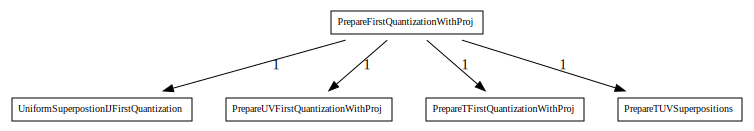

#### Counts totals:
 - `PrepareTFirstQuantizationWithProj`: 1
 - `PrepareTUVSuperpositions`: 1
 - `PrepareUVFirstQuantizationWithProj`: 1
 - `UniformSuperpostionIJFirstQuantization`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
prep_first_quant_g, prep_first_quant_sigma = prep_first_quant.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(prep_first_quant_g)
show_counts_sigma(prep_first_quant_sigma)

## `SelectFirstQuantizationWithProj`
SELECT operation for the first quantized chemistry Hamiltonian.

#### Parameters
 - `num_bits_p`: The number of bits to represent each dimension of the momentum register.
 - `eta`: The number of electrons.
 - `num_atoms`: The number of atoms. $L$ in the reference.
 - `lambda_zeta`: sum of nuclear charges.
 - `m_param`: $\mathcal{M}$ in the reference.
 - `num_bits_nuc_pos`: The number of bits of precision for representing the nuclear coordinates.
 - `num_bits_t`: The number of bits of precision for the state preparation over the register selecting between the different components of the Hamiltonian.
 - `num_bits_rot_aa`: The number of bits of precision for the rotation for amplitude amplification. 

#### Registers
 - `ham_ctrl`: Control bits flagging which component of the Hamiltonian to apply.
 - `i_ne_j`: Register flagging $i \ne j$
 - `plus_t`: A register prepared in the $|+\rangle$ state.
 - `i`: A register for selecting electronic registers.
 - `j`: A register for selecting electronic registers.
 - `w`: A register for selecting x, y and z components of the momentum register.
 - `r`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `s`: A register for controlling elements of the momentum register. Used for block encodiding kinetic energy operator.
 - `mu`: A register used for implementing nested boxes for the momentum state preparation.
 - `nu_x`: x component of the momentum register for Coulomb potential.
 - `nu_y`: y component of the momentum register for Coulomb potential.
 - `nu_z`: z component of the momentum register for Coulomb potential.
 - `m`: an ancilla register in a uniform superposition.
 - `l`: The register for selecting the nuclei.
 - `sys`: The system register. Will store $\eta$ registers (x, y and z) components of size num_bits_p.
 - `proj`: The system register. Will store a single register (x, y and z) components of size num_bits_n. 

#### References
 - [Fault-Tolerant Quantum Simulations of Chemistry in First Quantization](https://arxiv.org/abs/2105.12767). 


In [6]:
from qualtran.bloqs.chemistry.pbc.first_quantization.projectile import SelectFirstQuantizationWithProj

### Example Instances

In [7]:
num_bits_p = 6
num_bits_n = 8
eta = 10
num_atoms = 10
lambda_zeta = 10
sel_first_quant = SelectFirstQuantizationWithProj(
    num_bits_p, num_bits_n, eta, num_atoms, lambda_zeta
)


#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([sel_first_quant],
           ['`sel_first_quant`'])

### Call Graph

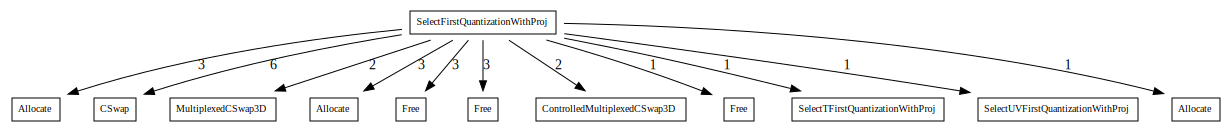

#### Counts totals:
 - `Allocate`: 1
 - `Allocate`: 3
 - `Allocate`: 3
 - `CSwap`: 6
 - `ControlledMultiplexedCSwap3D`: 2
 - `Free`: 1
 - `Free`: 3
 - `Free`: 3
 - `MultiplexedCSwap3D`: 2
 - `SelectTFirstQuantizationWithProj`: 1
 - `SelectUVFirstQuantizationWithProj`: 1

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
sel_first_quant_g, sel_first_quant_sigma = sel_first_quant.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(sel_first_quant_g)
show_counts_sigma(sel_first_quant_sigma)